# Poem Generation


In this notebook, we fine-tuned several pretrained transformer models from the transformers library by HuggingFace GPT2 with respect to different subcategories of poem. 
We self-taught how to fine tune GPT2 and use fastai following this Kaggle tutorial: https://www.kaggle.com/michaelarman/poem-generation-with-transformers

## Import Libraries


In [1]:
from fastai.text.all import *

In [2]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

In [3]:
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

## Read and Process Data
This data is organized by folder. There are one main folders: topics (e.g. love, peace, etc.). The main folder contains subfolders for the subcategories and then the poem txt files are contained in those.
 We read the data with the fastai get_text_files function and then select all folders or specific ones.

In [4]:
path = 'dataset/topics'

These are the subfolders.

In [5]:
relations=['brother', 'husband', 'birth', 'murder', 'friend', 'soldier', 'father', 'sister', 'death', 'suicide', 'childhood', 'family', 'girl', 'mother', 'funeral', 'son', 'baby', 'hero', 'children', 'teacher', 'daughter']
others=['power', 'green', 'home', 'running', 'sick', 'cinderella', 'car', 'change', 'together', 'memory', 'success', 'identity', 'loss', 'today', 'lost', 'football', 'sleep', 'poverty', 'silver', 'world', 'life', 'time', 'pink', 'hunting', 'red', 'warning', 'work', 'money', 'war', 'food', 'swimming', 'house', 'dark', 'remember', 'night', 'school', 'future', 'sometimes', 'hair', 'culture', 'believe', 'mirror']
emotions=['innocence', 'evil', 'passion', 'sorrow', 'love', 'freedom', 'fear', 'kiss', 'respect', 'funny', 'sympathy', 'racism', 'peace', 'beauty', 'greed', 'destiny', 'lust', 'laughter', 'happiness', 'truth', 'anger', 'beautiful', 'joy', 'justice', 'heaven', 'hate', 'faith', 'courage', 'dream', 'crazy', 'despair', 'god', 'happy','angel','depression','hope', 'trust','thanks']
locations=['paris', 'chicago', 'america', 'june', 'christmas', 'january']
arts=['music', 'song', 'poetry', 'dance', 'poem']
romances=['romance', 'marriage', 'wedding', 'lonely', 'romantic', 'alone']
travels=['travel','graduation', 'sun', 'rain', 'winter', 'weather', 'beach', 'summer', 'spring', 'ocean', 'river', 'water', 'sea','rose', 'moon','sky', 'city','nature','animal','snake','rainbow','frog','butterfly','star', 'fire']

### Generate Training and Testing Data 

In [6]:
relations = get_text_files(path, folders = relations)
print("There are ",len(relations)," relation poems in the dataset")
relations_test = relations[2000:2050]
relations = relations[:2000]

There are  2089  relation poems in the dataset


In [7]:
emotions = get_text_files(path, folders = emotions)
print("There are ",len(emotions)," emotion poems in the dataset")
emotions_test = emotions[2000:2050]
emotions=emotions[:2000]

There are  3783  emotion poems in the dataset


In [8]:
locations = get_text_files(path, folders = locations)
print("There are ",len(locations)," locations poems in the dataset")
locations_test=locations[500:550]
locations=locations[:500]

There are  598  locations poems in the dataset


In [9]:
arts = get_text_files(path, folders = arts)
print("There are ",len(arts)," arts poems in the dataset")
arts_test=arts[400:450]
arts=arts[:400]

There are  498  arts poems in the dataset


In [10]:
romances = get_text_files(path, folders = romances)
print("There are ",len(romances),"romances poems in the dataset")
romances_test=romances[500:550]
romances=romances[:500]

There are  599 romances poems in the dataset


In [11]:
travels = get_text_files(path, folders = travels)
print("There are ",len(travels)," travel poems in the dataset")
travels_test=travels[2000:2050]
travels=travels[:2000]

There are  2489  travel poems in the dataset


In [12]:
others = get_text_files(path, folders = others)
print("There are ",len(others)," other poems in the dataset")
others_test=others[2000:2050]
others=others[:2000]

There are  4180  other poems in the dataset


Later, we trained the model on each subcategories.

generate testing data


In [17]:
#create test file: each category have 50 random input sentence
import math
import random as rand
def create_test(test):
    test = L(o.open(encoding="utf8").read() for o in test)
    tmp = [i.split('\n') for i in test]
    output = []
    for i in range(50):
        lst = [j for j in tmp[i] if len(j)>1 or j.isalpha()]
        index = rand.randint(0,len(lst)-1)
#         index = math.ceil(len(lst)/4)-1
        output.append(lst[index])
    return output

In [30]:
with open('dataset/test', 'w') as f:
    relations_test_tmp = create_test(relations_test)
    emotions_test_tmp = create_test(emotions_test)
    locations_test_tmp = create_test(locations_test)
    romances_test_tmp = create_test(romances_test)
    travels_test_tmp = create_test(travels_test)
    arts_test_tmp = create_test(arts_test)
    others_test_tmp = create_test(others_test)
    test = relations_test_tmp+emotions_test_tmp+locations_test_tmp+romances_test_tmp+travels_test_tmp+arts_test_tmp+others_test_tmp
    for line in test:
        f.write(line)
        if test.index(line) != 349:
            f.write('\n')
    f.close()

## Prepare the Data



In [13]:
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

In [14]:
relations_poems = flatten(L(o.open(encoding="utf8").read() for o in relations))
emotions_poems = flatten(L(o.open(encoding="utf8").read() for o in emotions))
arts_poems = flatten(L(o.open(encoding="utf8").read() for o in arts))
travels_poems = flatten(L(o.open(encoding="utf8").read() for o in travels))
others_poems = flatten(L(o.open(encoding="utf8").read() for o in others))
romances_poems = flatten(L(o.open(encoding="utf8").read() for o in romances))
locations_poems = flatten(L(o.open(encoding="utf8").read() for o in locations))

In [15]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [16]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [17]:
splits = [range_of(1400), range(2000)]
splits1 = [range_of(280), range(400)]
splits2 = [range_of(350), range(500)]
relations = TfmdLists(relations_poems, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
emotions = TfmdLists(emotions_poems, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
arts = TfmdLists(arts_poems, TransformersTokenizer(tokenizer), splits=splits1, dl_type=LMDataLoader)
travels = TfmdLists(travels_poems, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
romances = TfmdLists(romances_poems, TransformersTokenizer(tokenizer), splits=splits2, dl_type=LMDataLoader)
locations = TfmdLists(locations_poems, TransformersTokenizer(tokenizer), splits=splits2, dl_type=LMDataLoader)
others = TfmdLists(others_poems, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [18]:
emotions = emotions.dataloaders(bs=4, seq_len=256)
arts = arts.dataloaders(bs=4, seq_len=256)
travels = travels.dataloaders(bs=4, seq_len=256)
romances = romances.dataloaders(bs=4, seq_len=256)
locations = locations.dataloaders(bs=4, seq_len=256)
others = others.dataloaders(bs=4, seq_len=256)

Token indices sequence length is longer than the specified maximum sequence length for this model (1261 > 1024). Running this sequence through the model will result in indexing errors


In [19]:
relations = relations.dataloaders(bs=4, seq_len=256)

In [20]:
relations.show_batch(max_n=2)

,text,text_
0,"Follow the ravens who gather\nin the weeping willows.\nSilent and starving\nnear the bank. Dusk curls at\nyour feet. You watch the busy\nhands of trees\npointing toward the river, divided\nby an island. A dead ash stands\nlike a bone knife\nPlunged into its chest. Black\nswans swimming in it's stomach.\nYou whisper a prayer for the dying.\nRiver bleeds over stone, smoothes\naway rough edges. While the\nmoon perches on edge of some\nunseen horizon. You wonder if\nstars seek a sense of place. Step\nover things as not to invade shadows.\nYou are certain they know the river\nis bleeding. Know that you are the\none story that began out of place.Most near, most dear, most loved, and most far,\nUnder the huge window where I often found her\nSitting as huge as Asia, seismic with laughter,\nGin and chicken helpless in her Irish hand,\nIrresistible as Rabelais but most tender for\nThe lame dogs and hurt birds that surround her,—\nShe is a procession no one can follow after\nBut be","the ravens who gather\nin the weeping willows.\nSilent and starving\nnear the bank. Dusk curls at\nyour feet. You watch the busy\nhands of trees\npointing toward the river, divided\nby an island. A dead ash stands\nlike a bone knife\nPlunged into its chest. Black\nswans swimming in it's stomach.\nYou whisper a prayer for the dying.\nRiver bleeds over stone, smoothes\naway rough edges. While the\nmoon perches on edge of some\nunseen horizon. You wonder if\nstars seek a sense of place. Step\nover things as not to invade shadows.\nYou are certain they know the river\nis bleeding. Know that you are the\none story that began out of place.Most near, most dear, most loved, and most far,\nUnder the huge window where I often found her\nSitting as huge as Asia, seismic with laughter,\nGin and chicken helpless in her Irish hand,\nIrresistible as Rabelais but most tender for\nThe lame dogs and hurt birds that surround her,—\nShe is a procession no one can follow after\nBut be"
1,"the unconquerable soul\nWait with an open heart my sisters and brothers\nHe is the one to make you whole\nBecause I know where I am going\n'I stand with the Father'a big brother\nis a guy i love to be around\nhe is a very close friend i found\na big brother\nis a guy who always seems\nto care and is always there\na big brother\nis a guy that i can look up to\nbecause he always knows what to do\na big brother\nis a guy i want to see\nhe will always understand me\nthat guy i talk about\nis not my big brother\nhe is just a brother\ni wish i hadthe house is almost full,\nthe rooms abound with chatter,\nlittle feet are pattering away\nfinally, the time that does matter,\nfervently with every breath of mine,\nI bow my head and pray,\nmy cup of happiness is full to the brim,\nsuch togetheness comes once in a way,\nmy loved ones are here with me\nto partake of","unconquerable soul\nWait with an open heart my sisters and brothers\nHe is the one to make you whole\nBecause I know where I am going\n'I stand with the Father'a big brother\nis a guy i love to be around\nhe is a very close friend i found\na big brother\nis a guy who always seems\nto care and is always there\na big brother\nis a guy that i can look up to\nbecause he always knows what to do\na big brother\nis a guy i want to see\nhe will always understand me\nthat guy i talk about\nis not my big brother\nhe is just a brother\ni wish i hadthe house is almost full,\nthe rooms abound with chatter,\nlittle feet are pattering away\nfinally, the time that does matter,\nfervently with every breath of mine,\nI bow my head and pray,\nmy cup of happiness is full to the brim,\nsuch togetheness comes once in a way,\nmy loved ones are here with me\nto partake of your"


## Fine-tuning the models

Note: This part is only for fine-tuing and exporting the models. At later stage, we skip this part to directly load the model.

SuggestedLRs(valley=1.2022644114040304e-05)

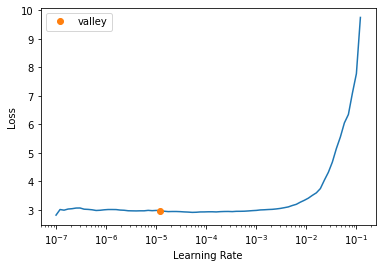

In [73]:
relation_learn = Learner(relations, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
relation_learn.validate()
relation_learn.lr_find()

In [74]:
relation_learn.fit_one_cycle(10, 1.2e-5)

epoch,train_loss,valid_loss,perplexity,time
0,2.951612,3.102397,22.251223,01:15
1,3.012803,3.088888,21.952662,01:14
2,2.961106,3.071057,21.564686,01:15
3,2.976606,3.052799,21.174519,01:16
4,2.954459,3.036911,20.840761,01:14
5,2.845340,3.024382,20.581274,01:15
6,2.863604,3.017542,20.440994,01:17
7,2.820207,3.011806,20.324078,01:14
8,2.923683,3.007955,20.245960,01:15
9,2.894695,3.009340,20.274015,01:16


In [75]:
relation_learn.save('relation')

Path('models/relation.pth')

SuggestedLRs(valley=0.00019054606673307717)

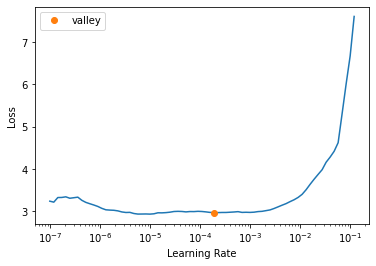

In [85]:
emotion_learn = Learner(emotions, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
emotion_learn.validate()
emotion_learn.lr_find()

In [86]:
emotion_learn.fit_one_cycle(10,1.9e-04)

epoch,train_loss,valid_loss,perplexity,time
0,2.995493,3.052713,21.172716,00:56
1,3.168221,2.971583,19.522799,00:53
2,2.963948,2.804272,16.515043,00:54
3,2.647579,2.630637,13.882609,00:55
4,2.417811,2.454672,11.642610,00:53
5,2.070485,2.341947,10.401472,00:53
6,1.788548,2.257018,9.554551,00:53
7,1.652126,2.230038,9.300219,00:52
8,1.472517,2.219947,9.206843,00:52
9,1.498507,2.223219,9.237019,00:52


In [87]:
emotion_learn.save('emotion')

Path('models/emotion.pth')

SuggestedLRs(valley=0.00010964782268274575)

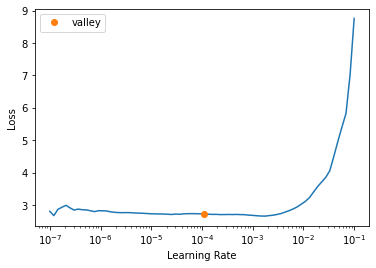

In [90]:
art_learn = Learner(arts, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
art_learn.validate()
art_learn.lr_find()

In [91]:
art_learn.fit_one_cycle(10,1.10e-04)

epoch,train_loss,valid_loss,perplexity,time
0,2.684881,2.999640,20.078299,00:21
1,2.704309,2.913205,18.415720,00:22
2,2.564162,2.773787,16.019176,00:21
3,2.348569,2.642531,14.048718,00:22
4,2.124556,2.528746,12.537776,00:22
5,1.900295,2.469101,11.811820,00:22
6,1.704186,2.445228,11.533180,00:22
7,1.589080,2.419999,11.245850,00:23
8,1.489971,2.411074,11.145930,00:21
9,1.437595,2.412501,11.161840,00:21


In [92]:
art_learn.save('art')

Path('models/art.pth')

SuggestedLRs(valley=0.00013182566908653826)

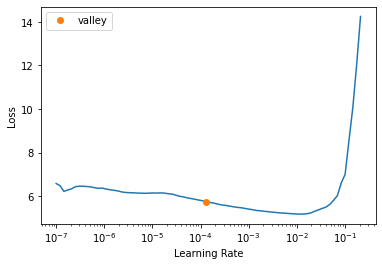

In [93]:
travel_learn = Learner(travels, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
travel_learn.validate()
travel_learn.lr_find()

In [94]:
travel_learn.fit_one_cycle(10, 1.32e-04)

epoch,train_loss,valid_loss,perplexity,time
0,4.316485,4.124159,61.815792,01:02
1,4.177077,3.878257,48.339886,01:02
2,3.929097,3.652662,38.577213,01:02
3,3.671200,3.452389,31.575729,01:04
4,3.383048,3.283694,26.674126,01:02
5,3.126638,3.149132,23.315823,01:03
6,2.928131,3.051028,21.137072,01:03
7,2.836345,3.000593,20.097460,01:03
8,2.750666,2.980871,19.704977,01:03
9,2.510788,2.982937,19.745722,01:04


In [95]:
travel_learn.save('travel')

Path('models/travel.pth')

SuggestedLRs(valley=3.630780702224001e-05)

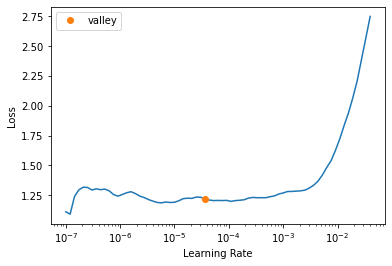

In [98]:
other_learn = Learner(others, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
other_learn.validate()
other_learn.lr_find()

In [99]:
other_learn.fit_one_cycle(10,3.63e-05)

epoch,train_loss,valid_loss,perplexity,time
0,1.132370,3.100529,22.209690,01:52
1,1.261375,3.093575,22.055798,01:55
2,1.200737,3.081910,21.799999,01:54
3,1.064715,3.090675,21.991909,01:55
4,1.161173,3.091291,22.005463,01:57
5,1.047454,3.105647,22.323648,01:56
6,0.997545,3.103767,22.281738,01:55
7,0.921590,3.102094,22.244492,01:56
8,0.917377,3.104819,22.305183,01:55
9,0.908038,3.106196,22.335926,01:57


In [100]:
other_learn.save('other')

Path('models/other.pth')

SuggestedLRs(valley=0.0003981071640737355)

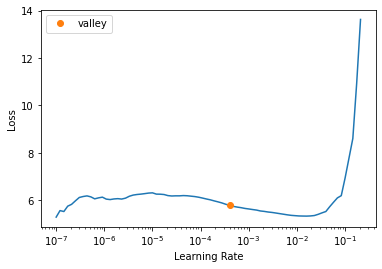

In [101]:
romance_learn = Learner(romances, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
romance_learn.validate()
romance_learn.lr_find()

In [102]:
romance_learn.fit_one_cycle(10,3.98e-04)

epoch,train_loss,valid_loss,perplexity,time
0,4.591326,4.164698,64.373215,00:23
1,4.139003,3.711403,40.911160,00:23
2,3.685023,3.219860,25.024612,00:23
3,3.052644,2.752032,15.674443,00:23
4,2.391212,2.384943,10.858446,00:23
5,1.768211,2.192263,8.955456,00:23
6,1.260497,2.139238,8.492965,00:23
7,0.941248,2.122914,8.355451,00:23
8,0.765496,2.111933,8.264196,00:23
9,0.726696,2.114246,8.283335,00:23


In [103]:
romance_learn.save('romance')

Path('models/romance.pth')

SuggestedLRs(valley=0.0003981071640737355)

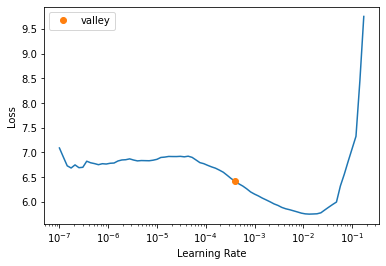

In [104]:
location_learn = Learner(locations, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
location_learn.validate()
location_learn.lr_find()

In [109]:
location_learn.fit_one_cycle(10,3.98e-04)

epoch,train_loss,valid_loss,perplexity,time
0,4.903385,4.478212,88.077042,00:26
1,4.364394,4.013156,55.321186,00:27
2,3.867980,3.508348,33.393055,00:28
3,3.270598,3.054212,21.204466,00:27
4,2.612363,2.710852,15.042091,00:27
5,1.966392,2.495597,12.128968,00:27
6,1.456591,2.402530,11.051097,00:27
7,1.086690,2.411347,11.148965,00:28
8,0.953092,2.394927,10.967395,00:28
9,0.890973,2.396852,10.988525,00:27


In [110]:
location_learn.save('location')

Path('models/location.pth')

## Poem Generation Example

In [76]:
prompt = 'When the wind blows over the field'
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 7])

In [80]:
preds = relation_learn.model.generate(inp, do_Sample=True, temperature=0.95, max_length=200, top_k=50, top_p=0.9, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
When the wind blows over the field,
And the sun goes down, and the stars go down;
Then, when all is said and done, the funeral dirge
Shall be heard around the town.
The funeral car will come to the scene
Where all the mourners are gathered, to pay their respects
To the departed loved ones who have passed away.There was a time when I was just a child
When my world seemed so bright and full of hope
My world was filled with hope and joy
But now it is gone
There is no more hope for me in this world
I can no longer go to school
No more friends that I can call my own
With no one to cheer me up
So I decided to take my chances with my life
Started a new life with a smile on my face
Now I am ready to give my all for my family and friends
Thank you Father God for giving me the strength I need to


## How to load the model - Example

In [37]:
learn1=Learner(romances, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
learn1.load('romance')

In [39]:
prompt = 'When the wind blows over the field'
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None]

In [40]:
preds = learn1.model.generate(inp, do_Sample=True, temperature=0.95, max_length=200, top_k=50, top_p=0.9, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
When the wind blows over the field, and the crowd
Swept past me like a rushing sea,
And I was hurled from my dream onto the shore
Where the swift-winged gull flies gliding o'er the glade;
But now I am始 in the wild, thronging many a windy wave
To the glittering gull's boundless life; but oh! how I feared
I should lift my arms and ride with me this morning
Among the dancing shadows of the birds -- O, they are wings
Of the purest beauty that I have seen: --
Thou art not worthy even to speak of him!
For though he loved and reverenced me, he is not
 worthy to be the man I see in
The flesh of men:  he can neither love nor hate
One another so much as live and love.
Therefore, O Lord, be glad thou never more
Will clothe thyself with


## Generation Evaluation

### Evaluation Metrics

In [21]:
import collections, nltk
from textatistic import Textatistic
#tokenize the text corpus
def create_tokens(all_poems):
    tokens = []
    for i in all_poems:
        tmp_tokens = nltk.word_tokenize(i)
        tokens += tmp_tokens
    return tokens
   

#construct the unigram language model 
def unigram(tokens):    
    model = collections.defaultdict(lambda: 0.01)
    for f in tokens:
        try:
            model[f] += 1
        except KeyError:
            model [f] = 1
            continue
    N = float(sum(model.values()))
    for word in model:
        model[word] = model[word]/N
    return model
#https://towardsdatascience.com/perplexity-in-language-models-87a196019a94
#https://stackoverflow.com/questions/33266956/nltk-package-to-estimate-the-unigram-perplexity
#computes perplexity of the unigram model on a testset  
def perplexity(testset, model):
    testset = testset.split()
    testset = [i for i in testset if i in model]
    perplexity = 1
    N = 0
    for word in testset:
        N += 1
        perplexity = perplexity * (1/model[word])
    perplexity = pow(perplexity, 1/float(N)) 
    return perplexity

def evaluation(pp_model, sentence):
#     learn=Learner(model_name, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
#     learn.load(model_file)
    
   # create an initial text prompt to start generated text
    prompt_ids = tokenizer.encode(sentence)
    inp = tensor(prompt_ids)[None]
    preds = learn.model.generate(inp, do_Sample=True, temperature=0.95, max_length=200, top_k=50, top_p=0.9, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
    text = tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True)
    s = Textatistic(deal_text(text))
    score_dict = s.scores
    p = perplexity(text, pp_model)
#     score_dict['perplexity'] = p
    return text, score_dict, p

from nltk.translate.bleu_score import sentence_bleu
import copy
#diversity
#self_bleu: access the similarity between every document and the rest of the generated collection  
#           A lower Self-BLEU score implies higher diversity of the collection
#reference: https://arxiv.org/pdf/2108.03578.pdf  https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

def self_bleu(pred_lst):
    score = []
    pred_token = []
    for i in pred_lst:
        tmp_tokens = nltk.word_tokenize(i)
        pred_token.append(tmp_tokens) 
    for candidate in pred_token:
        tmp = copy.deepcopy(pred_token)
        tmp.remove(candidate)
        score.append(sentence_bleu(tmp, candidate))
    return np.mean(score)
#     return score

def deal_text(text):
    tmp = text.split('\n')
    out = []
    for i in tmp:
#         print(i)
#         print(i[-1])
    
        try:
            t = i[-1]
        except IndexError:
            i += '.'
        else:
            if i[-1].isalpha():
                i += '.'   
        out.append(i)
    out = "\n".join(out)  
    return out

### Evaluation on Testing Data

In [22]:
###code reference
#https://www.kaggle.com/fshenbayh/readability

###scores reference
#https://en.wikipedia.org/wiki/Readability#Popular_readability_formulas

#flesch_score -Flesch Reading East Score: higher scores indicate material that is easier to read
#fleschkincaid_score -Flesch-Kincaid Grade: the number of years of education generally required to understand this text, relevant when the formula results in a number greater than 10.
#gunningfog_score - :weighted average of the number of words per sentence, and the number of long words per word, lower - easier
#smog_score -McLaughlin's SMOG formula :approximates the age needed to understand the text, i.e. lower - easier
#dalechall_score -Dale-Chall Readability socre: Provides a numeric gauge of the comprehension difficulty that readers come upon when reading a text

#read the test file
f = open('dataset/test', 'r')
text = f.read()
text = text.split('\n')

eval_lst = ['flesch_score',
            'fleschkincaid_score',
            'gunningfog_score',
            'smog_score',
            'dalechall_score',
            'perplexity',
            'self_bleu']

def conclude_score(text, eval_lst, all_poems):
    
    tokens = create_tokens(all_poems) 
    pp_model = unigram(tokens)
    pred_lst = []
    score_lst = []
    pp_lst = []
    for i in text:
        sent, score_dict, p = evaluation(pp_model, i)
        pred_lst.append(sent)
        score_lst.append(score_dict)
        pp_lst.append(p)
    self_bleu_score = self_bleu(pred_lst)
    report_lst = []
    for key in eval_lst[:-2]:
        report_lst.append(np.mean([item[key] for item in score_lst]))
    pp_lst = [i for i in pp_lst if i != float("inf")]
    if len(pp_lst) == 0:
        pp_lst = [float("inf")]
    p = np.mean(pp_lst)
    report_lst.append(p)
    report_lst.append(self_bleu_score)
    report_lst = [round(i, 3) for i in report_lst]
    return pred_lst, report_lst

In [23]:
#relations
learn=Learner(relations, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
learn.load('relation')
pred_lst_1, report_lst_1 = conclude_score(text, eval_lst, relations_poems)


/Users/ruby0907/opt/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/Users/ruby0907/opt/anaconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independ

In [24]:
#emotions
learn=Learner(emotions, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
learn.load('emotion')
pred_lst_2, report_lst_2 = conclude_score(text, eval_lst, emotions_poems)



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [25]:
#arts
learn=Learner(arts, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
learn.load('art')
pred_lst_3, report_lst_3 = conclude_score(text, eval_lst, arts_poems)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [26]:

#travels
learn=Learner(travels, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
learn.load('travel')
pred_lst_4, report_lst_4 = conclude_score(text, eval_lst, travels_poems)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [58]:
#romances
learn=Learner(romances, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
learn.load('romance')
pred_lst_5, report_lst_5 = conclude_score(text, eval_lst, romances_poems)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [33]:
#locations
learn=Learner(locations, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
learn.load('location')
pred_lst_6, report_lst_6 = conclude_score(text, eval_lst, locations_poems)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [34]:
#others
learn=Learner(others, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
learn.load('other')
pred_lst_7, report_lst_7 = conclude_score(text, eval_lst, others_poems)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [63]:
c_m = [report_lst_1, report_lst_2, report_lst_3, report_lst_4, report_lst_5, report_lst_6, report_lst_7]
index = ['relation', 'emotion', 'art', 'travel', 'romance', 'location', 'other']
report_df = pd.DataFrame(c_m, index=index, columns = eval_lst)
report_df

,flesch_score,fleschkincaid_score,gunningfog_score,smog_score,dalechall_score,perplexity,self_bleu
relation,100.707,1.722,4.788,5.323,4.175,372.74820,0.537
emotion,97.310,2.073,5.012,5.921,5.846,30.40945,0.446
art,99.616,1.338,4.116,5.338,5.656,11.17932,0.441
travel,100.236,1.714,4.828,5.444,4.687,207.99898,0.474
romance,100.221,1.227,4.021,5.264,6.250,21.17002,0.495
location,96.584,2.185,5.081,5.893,6.319,34.38060,0.429
other,99.596,1.601,4.406,5.305,5.933,132.01411,0.379
